In [1]:
import json
import requests
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random
import glob
import zipfile
import os
import shutil

In [60]:
class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [61]:
class Coord(object):
    """Coordinate.

    Parameters
    ----------
    lat : <float> latitude
    lon : <float> longitude
    latlon : <list> list with both lat and long. Latitude first!
    """
    def __init__(self, lat=None, lon=None, latlon=None):
        if latlon is not None:
            if len(latlon) != 2:
                raise Exception("Wrong coordinate latlon format. Should be a list of two floats.")
            self.lat = latlon[0]
            self.lon = latlon[1]
        elif lat is None or lon is None:
            raise Exception("Coordinates not provided")
        else:
            self.lat = lat
            self.lon = lon

    def to_json(self):
        return json.dumps(self, default=lambda o: self._try(o), sort_keys=True, indent=4, separators=(',', ':'))

    @staticmethod
    def _try(o):
        try:
            if o.__class__ == Coord:
                raise Exception()
            return o.__dict__
        except:
            return str(o)
        
    def __str__(self):
        return str(self.lat) + ',' + str(self.lon)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lat == other.lat and self.lon == other.lon

    def __hash__(self):
        return hash((self.lat, self.lon))


In [62]:
class Leg(object):
    """Leg of a trip. For example, "walk - bus - walk" trip has three legs.
    Used to store trip legs from OTP.

    Parameters
    ----------
    mode : <str> mode of transport
    start_coord : <coord> coordinate of an origin
    end_coord : <coord> coordinate of a destination
    distance : <int> meters
    duration : <int> seconds
    steps : <list> of utils.Step
    """

    # TODO:assignment of mode   as a string is confusing, remove it, or use constant
    def __init__(self, mode=None, start_coord=None, from_stop=None, end_coord=None, to_stop=None,
                 start_time=None, end_time=None,
                 distance=None, duration=None, steps=None):
        self.mode = mode
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration
        self.steps = steps
        # The two below only used for PT legs
        self.from_stop = from_stop
        self.to_stop = to_stop

        self.start_time = start_time
        self.end_time = end_time

    def deepcopy(self):
        if self.steps is None:
            steps = []
        else:
            steps = [step.deepcopy() for step in self.steps if step is not None]
        return Leg(mode=copy.copy(self.mode),
                   start_coord=copy.copy(self.start_coord),
                   from_stop=copy.copy(self.from_stop),
                   end_coord=copy.copy(self.end_coord),
                   to_stop=copy.copy(self.to_stop),
                   start_time=copy.copy(self.start_time),
                   end_time=copy.copy(self.end_time),
                   distance=copy.copy(self.distance),
                   duration=copy.copy(self.duration),
                   steps=steps)


In [63]:
class Trip(object):
    """A list of legs and a total trip duration
    """
    legs = ...  # type: List[Leg]

    def __init__(self):
        self.legs = []
        self.duration = None
        self.distance = None
        self.main_mode = None

    def set_empty_trip(self, mode, coord_start, coord_end):
        """Sets a dummy trip between two coordinates with zero distance, duration and one empty leg"""
        self.set_duration(0)
        self.set_distance(0)
        self.main_mode = mode
        self.legs = [Leg(mode=mode, start_coord=coord_start, end_coord=coord_end, distance=0, duration=0,
                         steps=[Step(coord_start, coord_end, 0, 0)])]

    def dumps(self):
        return self.__dict__

    def get_leg_modes(self):
        """Returns a list of modes from the legs"""
        return [l.mode for l in self.legs]

    def deepcopy(self):
        nt = Trip()
        nt.duration = copy.copy(self.duration)
        nt.distance = copy.copy(self.distance)
        nt.main_mode = copy.copy(self.main_mode)
        nt.legs = [leg.deepcopy() for leg in self.legs]
        return nt

    def main_mode_from_legs(self):
        leg_modes = self.get_leg_modes()

        if LegMode.CAR in leg_modes:
            return OtpMode.CAR
        elif LegMode.BUS in leg_modes or LegMode.SUBWAY in leg_modes or \
                LegMode.TRAM in leg_modes or LegMode.RAIL in leg_modes:
            return OtpMode.TRANSIT
        elif LegMode.BICYCLE in leg_modes:
            return OtpMode.BICYCLE
        elif LegMode.WALK in leg_modes:
            return OtpMode.BICYCLE
        else:
            log.error('Main mode unrecognized. Returning None. Kick the developer to make a proper function.')
            return None

    def set_duration(self, dur):
        self.duration = dur

    def set_main_mode(self, mode):
        self.main_mode = mode
    
    def set_distance(self, dist):
        self.distance = dist
    
    def append_leg(self, leg):
        self.legs.append(leg)
        
    def __str__(self):
        return '{} trip, takes {} distance {}'\
            .format(self.main_mode, self.duration, self.distance)

    def __repr__(self):
        return str(self)


In [64]:
class Step(object):
    """Arguments:|
    start_coord       <Coord>|
    distance    <int>|
    duration    <int>|
    """
    def __init__(self, start_coord, end_coord, distance, duration):
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration

    @staticmethod
    def get_empty_step(coord):
        return Step(start_coord=coord, end_coord=coord, distance=0, duration=0)

    def deepcopy(self):
        return Step(start_coord=copy.copy(self.start_coord),
                    end_coord=copy.copy(self.end_coord),
                    distance=copy.copy(self.distance),
                    duration=copy.copy(self.duration),
                    )

    def dumps(self):
        return self.__dict__

    def __str__(self):
        return 'Step distance {:.1f}, duration {:.1f}'.format(self.distance, self.duration)

    def __repr__(self):
        return self.__str__()


In [65]:
def osrm_route_request(from_place, to_place):
    url_coords = '{}{},{};{},{}' \
        .format('http://0.0.0.0:5000/route/v1/driving/',
                from_place.get('lon'), from_place.get('lat'), to_place.get('lon'), to_place.get('lat'))
    url_full = url_coords + '?annotations=true&geometries=geojson&steps=true'
    resp = requests.get(url=url_full)
    return _parse_osrm_response(resp)


def _parse_osrm_response(resp):
    # if resp.status_code != requests.codes.ok:
    #     resp.raise_for_status()

    jresp = resp.json()
    # if jresp.get('code') != 'Ok':
    #     log.error(jresp.get('code'))
    #     log.error(jresp.get('message'))
    #     resp.raise_for_status()

    trip = Trip()
    trip.legs = [Leg()]
    trip.legs[0].steps = []

    legs = jresp.get('routes')[0].get('legs')
    for leg in legs:
        steps = leg.get('steps')
        for step in steps:
            new_step = Step(distance=step.get('distance'),
                            duration=step.get('duration'),
                            start_coord=Coord(lon=step.get('geometry').get('coordinates')[0][0],
                                              lat=step.get('geometry').get('coordinates')[0][1]),
                            end_coord=Coord(lon=step.get('geometry').get('coordinates')[-1][0],
                                            lat=step.get('geometry').get('coordinates')[-1][1]))
            # OSRM makes circles on roundabouts. And makes empty step in the end. Exclude these cases from a route
            if new_step.start_coord != new_step.end_coord:
                trip.legs[0].steps.append(new_step)
        if len(trip.legs[0].steps) == 0:
            waypoints = jresp.get('waypoints')
            trip.legs[0].steps.append(Step(distance=0,
                                           duration=0,
                                           start_coord=Coord(lon=waypoints[0].get('location')[0],
                                                             lat=waypoints[0].get('location')[1]),
                                           end_coord=Coord(lon=waypoints[1].get('location')[0],
                                                           lat=waypoints[1].get('location')[1])
                                           )
                                      )
    trip.legs[0].start_coord = trip.legs[0].steps[0].start_coord
    trip.legs[0].end_coord = trip.legs[0].steps[-1].end_coord
    trip.legs[0].duration = sum([step.duration for step in trip.legs[0].steps])
    trip.legs[0].distance = sum([step.distance for step in trip.legs[0].steps])
    trip.legs[0].mode = OtpMode.DRT

    trip.distance = trip.legs[0].distance
    trip.duration = trip.legs[0].duration
    trip.main_mode = OtpMode.CAR
    return trip


In [768]:
scenario_name = "4"
path_to_zip_file = '/home/ai6644/Malmo/Tools/Simulation results/Lolland/TRB/drt/dtm 1.3/'+\
                   scenario_name+'/log.zip'

In [769]:
day_sec = int(86400)
day_h = int(24)

In [770]:
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    try:
        shutil.rmtree('data/zip')
    except (FileNotFoundError, OSError) as e:
        pass
    os.mkdir('data/zip')
    zip_ref.extractall('data/zip')
path = 'data/zip/' + os.listdir('data/zip')[0] + '/trip_dump.json'

In [771]:
all_files = glob.glob("data/zip/*/vehicle_logs/vehicle_occupancy_*")
n_cars = len(all_files)

In [772]:
# n_cars = 25

In [773]:
fp = open(path)
tdump = json.load(fp)
fp.close()

In [774]:
persons = tdump.get('person')

In [775]:
drt_legs = []
for person in persons:
    trips = person.get('actual_trips')
    for trip in trips:
            legs = [leg for leg in trip.get('legs') if leg.get('mode') in ['DRT', 'DRT_TRANSIT']]
            if len(legs) > 0:    
                drt_legs += legs
#                 direct_legs += [leg.get('duration') for leg in act.get('legs') if leg.get('mode') in ['DRT', 'DRT_TRANSIT']])
                


In [776]:
len(drt_legs)

1185

In [777]:
direct_seconds_drt_only = sum([osrm_route_request(leg.get('start_coord'), leg.get('end_coord')).duration for leg in drt_legs])

In [778]:
direct_minutes = direct_seconds_drt_only / 60
print(direct_minutes)
print(str(direct_minutes).replace('.',','))

11599.531666666648
11599,531666666648


In [779]:
drt_minutes = sum([leg.get('duration') for leg in drt_legs]) / 60
print(drt_minutes)

17978.973333333295


In [780]:
direct_minutes / drt_minutes

0.6451720824993347

In [781]:
(drt_minutes - direct_minutes) / direct_minutes

0.5499740722290648

### direct kilometers, but VKT is WRONG!

In [782]:
drt_vkt = sum([leg.get('distance') for leg in drt_legs])

In [783]:
drt_vkt/1000

10209.151099999995

In [784]:
direct_vkt = sum([osrm_route_request(leg.get('start_coord'), leg.get('end_coord')).distance for leg in drt_legs])

In [785]:
print(str(direct_vkt/1000).replace('.',','))

9352,88489999999


In [713]:
direct_vkt/drt_vkt

0.9175714669810386

In [27]:
direct_trips_drt = []
direct_trips_drt_transit = []
drt_trips = []
drt_transit_trips = []
for person in persons:
    for drt_trip, direct_trip in zip(person.get('actual_trips'), person.get('direct_trips')):
        if drt_trip.get('main_mode') == OtpMode.DRT:
            direct_trips_drt.append(direct_trip)
            drt_trips.append(drt_trip)
        elif drt_trip.get('main_mode') == OtpMode.DRT_TRANSIT:
            direct_trips_drt_transit.append(direct_trip)
            drt_transit_trips.append(drt_trip)

In [28]:
direct_seconds_drt = sum([trip.get('duration') for trip in direct_trips_drt])
direct_seconds_drt_transit = sum([trip.get('duration') for trip in direct_trips_drt_transit])
drt_transit_seconds = sum([trip.get('duration') for trip in drt_transit_trips])
drt_seconds = sum([trip.get('duration') for trip in drt_trips])

In [29]:
direct_seconds_drt / 60

16103.786666666647

In [30]:
len(drt_trips)

1554

In [31]:
if direct_seconds_drt > 0:
    print((drt_seconds - direct_seconds_drt) / direct_seconds_drt)

0.882553244205919


In [32]:
if direct_seconds_drt_transit > 0:
    print((drt_transit_seconds - direct_seconds_drt_transit) / direct_seconds_drt_transit)

0.498009543693514


In [33]:
direct_minutes_full_trip = (direct_seconds_drt + direct_seconds_drt_transit) / 60
direct_minutes_full_trip

26075.1183333333

In [34]:
direct_vkt_whole_trip_drt_transit = sum([trip['distance'] for trip in direct_trips_drt_transit]) /1000
direct_vkt_whole_trip_drt_transit

10314.207199999997

### Histogram for deviation time

In [35]:
direct_seconds_drt_transit = [trip.get('duration') for trip in direct_trips_drt_transit]
seconds_drt_transit = [trip.get('duration') for trip in drt_transit_trips]

In [36]:
deviation_drt_transit = [a/(d+120) for d,a in zip(direct_seconds_drt_transit, seconds_drt_transit)]

Text(0.5, 1.0, 'Distribution of actual/direct trip time for DRT_TRANSIT')

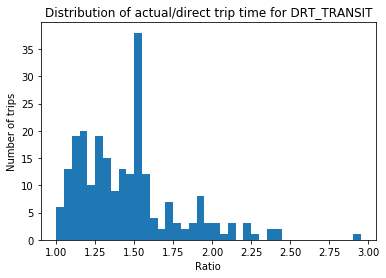

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=deviation_drt_transit, bins=np.arange(1,3,0.05))
plt.xlabel('Ratio')
plt.ylabel('Number of trips')
plt.title('Distribution of actual/direct trip time for DRT_TRANSIT')

In [38]:
direct_seconds_drt = [trip.get('duration') for trip in direct_trips_drt]
actual_seconds_drt = [trip.get('duration') for trip in drt_trips]

In [39]:
deviation_drt = [a/(d+120) for d,a in zip(direct_seconds_drt, actual_seconds_drt)]

Text(0.5, 1.0, 'Distribution of actual/direct trip time for DRT')

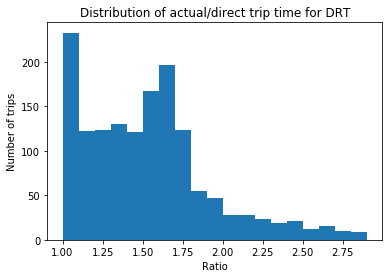

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=deviation_drt, bins=np.arange(1,3,0.1))
# ax.hist(x=deviation_drt, bins=[1,1.05,2])
plt.xlabel('Ratio')
plt.ylabel('Number of trips')
plt.title('Distribution of actual/direct trip time for DRT')
# plt.ylim(0, 1600)

Text(0.5, 1.0, '')

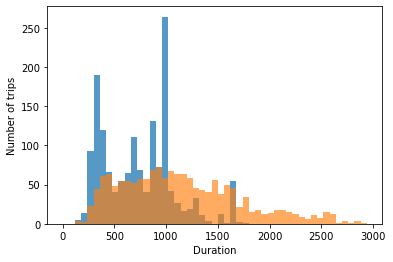

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=[x+120 for x in direct_seconds_drt], bins=np.arange(0,50*60,60), alpha=0.75)
ax.hist(x=actual_seconds_drt, bins=np.arange(0,50*60,60), alpha=0.65)
plt.xlabel('Duration')
plt.ylabel('Number of trips')
plt.title('')

### Demand distribution

error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 252}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 266}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 389}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 699}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 705}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 928}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1028}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1091}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1237}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1417}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1454}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1694

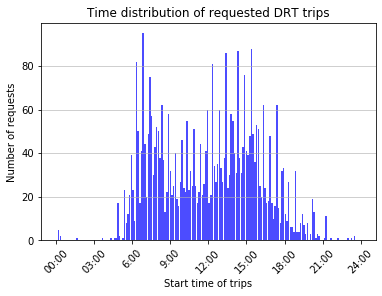

In [42]:
time_requested_trips = []
for person in persons:
    try:
        time_requested_trips.append(person['actual_trips'][0]['legs'][0]['start_time'])
    except:
        print('error for {}'.format(person))
        continue
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=time_requested_trips, bins=np.arange(0,day_sec+1,day_sec/day_h*8/60), color='blue', alpha=0.7, rwidth=0.85, density=False)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips')
plt.ylabel('Number of requests')
plt.title('Time distribution of requested DRT trips')

plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 252}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 266}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 389}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 699}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 705}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 928}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1028}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1091}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1237}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1417}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1454}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1694

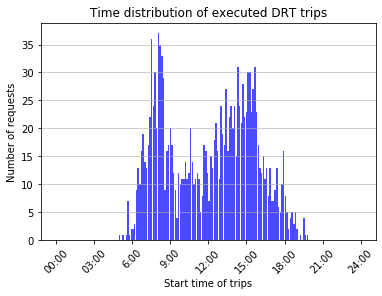

In [43]:
time_requested_trips = []
for person in persons:
    try:
        if person['actual_trips'][0]['main_mode'] in ['DRT']:
            time_requested_trips.append(person['actual_trips'][0]['legs'][0]['start_time'])
    except:
        print('error for {}'.format(person))
        continue
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=time_requested_trips, bins=np.arange(0,day_sec+1,day_sec/day_h*8/60), color='blue', alpha=0.7, rwidth=0.85, density=False)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips')
plt.ylabel('Number of requests')
plt.title('Time distribution of executed DRT trips')

plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 252}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 266}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 389}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 699}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 705}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 928}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1028}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1091}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1237}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1417}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1454}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1694

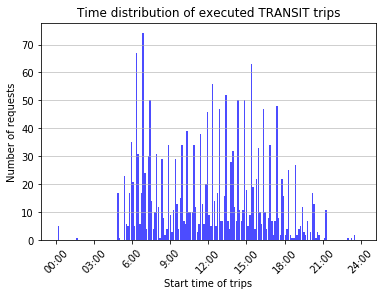

In [44]:
time_requested_trips = []
for person in persons:
    try:
        if person['actual_trips'][0]['main_mode'] in ['TRANSIT,WALK']:
            time_requested_trips.append(person['actual_trips'][0]['legs'][0]['start_time'])
    except:
        print('error for {}'.format(person))
        continue
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=time_requested_trips, bins=np.arange(0,day_sec+1,day_sec/day_h*8/60), color='blue', alpha=0.7, rwidth=0.85, density=False)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips')
plt.ylabel('Number of requests')
plt.title('Time distribution of executed TRANSIT trips')

plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 252}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 266}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 389}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 699}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 705}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 928}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1028}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1091}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1237}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1417}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1454}
error for {'actual_trips': [], 'planned_trips': [], 'direct_trips': [], 'id': 1694

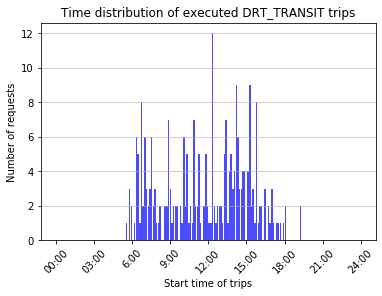

In [45]:
time_requested_trips = []
for person in persons:
    try:
        if person['actual_trips'][0]['main_mode'] in ['DRT_TRANSIT']:
            time_requested_trips.append(person['actual_trips'][0]['legs'][0]['start_time'])
    except:
        print('error for {}'.format(person))
        continue
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=time_requested_trips, bins=np.arange(0,day_sec+1,day_sec/day_h*8/60), color='blue', alpha=0.7, rwidth=0.85, density=False)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips')
plt.ylabel('Number of requests')
plt.title('Time distribution of executed DRT_TRANSIT trips')

plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)

plt.savefig('data/demand_distr.png', dpi=600)

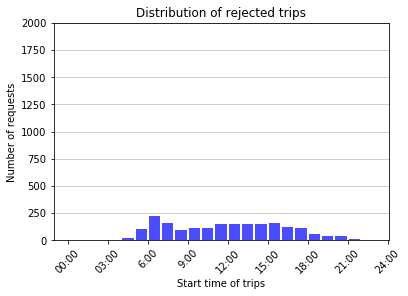

In [46]:
#  also includes rejected by distance and no pt stop
time_rejected_trips = []
for person in persons:
    for trip in person.get('actual_trips'):
        if trip.get('main_mode') not in [OtpMode.DRT, OtpMode.DRT_TRANSIT]:
            time_rejected_trips.append(trip.get('legs')[0].get('start_time'))

# Distribution of rejected trips

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x=time_rejected_trips, bins=np.arange(1,86400,86401/24), color='blue', alpha=0.7, rwidth=0.85, density=False)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips')
plt.ylabel('Number of requests')
# plt.xlabel('Start time of work trip')
# plt.ylabel('Frequency')
plt.title('Distribution of rejected trips')
plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)

plt.ylim(ymax=2000, ymin=0)
plt.savefig('data/rejected_all.png', dpi=600)

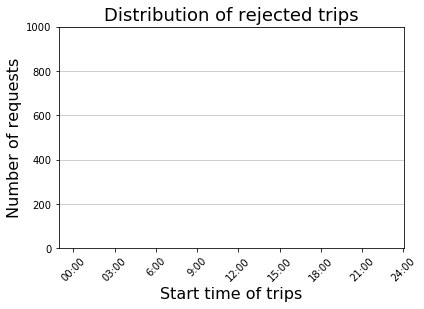

In [47]:
time_rejected_trips = []
for person in persons:
    for trip in person.get('actual_trips'):
        if trip.get('main_mode') in [OtpMode.CAR]:
            time_rejected_trips.append(trip.get('legs')[0].get('start_time'))
            
# Distribution of rejected trips

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.8, 0.77])
ax.hist(x=time_rejected_trips, bins=np.arange(1,86400,86401/24), color='blue', alpha=0.7, rwidth=0.85, density=False)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips', fontsize=16)
plt.ylabel('Number of requests', fontsize=16)
# plt.xlabel('Start time of work trip')
# plt.ylabel('Frequency')
plt.title('Distribution of rejected trips', fontsize=18)
plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)


plt.ylim(ymax=1000, ymin=0)
plt.savefig('data/rejected_car.png', dpi=600)

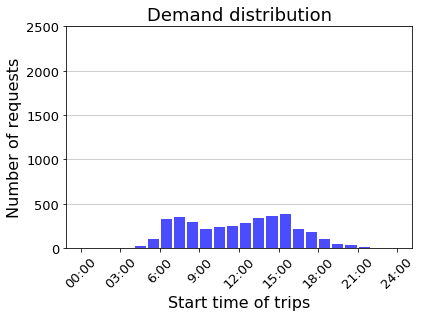

In [48]:
trips = []
for person in persons:
    for trip in person.get('actual_trips'):
        trips.append(trip.get('legs')[0].get('start_time'))
            
# Distribution of rejected trips

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.8, 0.77])
ax.hist(x=trips, bins=np.arange(0,86401,86400/24), color='blue', alpha=0.7, rwidth=0.85, density=False)
#n, bins, patches = plt.hist(x=upsampled_wl['work_journey_start_time'], bins=np.arange(1,24,.5), color='grey',
                           # alpha=0.7, rwidth=0.85, density=1) #, stacked=True, density=True
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Start time of trips', fontsize=16)
plt.ylabel('Number of requests', fontsize=16)
plt.title('Demand distribution', fontsize=18)
plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]], fontsize=13)
plt.yticks(fontsize=13)
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)


plt.ylim(ymax=2500, ymin=0)
plt.savefig('data/demand_distr.png', dpi=600)

In [49]:
len(time_rejected_trips)

14

In [50]:
drt_legs = []
for person in persons:
    for trip in person.get('actual_trips'):
        if trip.get('main_mode') in [OtpMode.DRT, OtpMode.DRT_TRANSIT]:
            for leg in trip['legs']:
                if leg['mode'] == 'DRT':
                    drt_legs.append(leg)

In [51]:
end_times = [leg['end_time'] for leg in drt_legs]

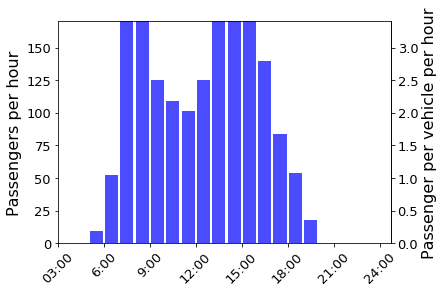

In [52]:
fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.77, 0.77])
plt.rcParams.update({'font.size': 13})
distr = ax.hist(x=end_times, bins=np.arange(0,86401,86400/24), color='blue', alpha=0.7, rwidth=0.85, density=False)
ax.set_ylabel('Passengers per hour', fontsize=16)
secaxy = ax.secondary_yaxis('right', functions=(lambda x: x/n_cars, lambda x: x*n_cars))
secaxy.set_ylabel('Passenger per vehicle per hour', fontsize=16)
# plt.title('Distribution of passengers per hour', fontsize=18)
plt.xticks([x*3600 for x in [0, 3, 6, 9, 12, 15, 18, 21, 24]])
names_x = ['00:00','03:00','6:00','9:00','12:00','15:00','18:00','21:00', '24:00']
ax.set_xticklabels(names_x,rotation=45)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.ylim(0,170)
plt.xlim(3*60*60,89000)
plt.savefig('data/pass_per_hour_drt.svg', dpi=600, bbox_inches="tight")

In [53]:
print(sum(distr[0])/day_h/n_cars, ' -mean passengers per hour per vehicle')
print(sum(distr[0][5:])/(day_h-4)/n_cars, ' - excluding 0-3 hours interval')
print(sum(distr[0][5:])/(day_h-4-3)/n_cars, ' - excluding 0-3 and 21-24 hours interval')

1.5091666666666665  -mean passengers per hour per vehicle
1.811  - excluding 0-3 hours interval
2.130588235294118  - excluding 0-3 and 21-24 hours interval
